In this new version, we will remove the first and last image of each frame

In [32]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import pprint
import os

import matplotlib.pyplot as plt
%matplotlib notebook

from NeuNorm.normalization import Normalization

# Instructions 

Here we define the only 2 input parameters to the program
 * input_folder
 * output_folder

In [33]:
input_folder = "data/raw_data/"
assert Path(input_folder).exists()

In [34]:
output_folder = 'data/corrected_data_calculated'
assert Path(output_folder).exists()

## This is only for testing purpose 

In [35]:
expected_folder = 'data/corrected_data_expected/'
assert Path(expected_folder).exists()

# Setup 

In [36]:
shutter_dict = {}

### ShutterCount.txt 

First, the program will locate, in that folder, the file names that ends by *_ShutterCount.txt* and read it in order to isolate the number of count for each shutter.

__Handling errors__: If file can not be located, error should be raised ("Missing ShutterCount.txt in folder")

In [37]:
shutter_count_file = glob.glob(input_folder + '/*_ShutterCount.txt')[0]
assert Path(shutter_count_file).exists()

In [38]:
shutter_count_pd = pd.read_csv(shutter_count_file, sep='\t', names=['shutter_index', 
                                                                    'shutter_counts'])

# isolate only the shutter counts
shutter_counts = shutter_count_pd['shutter_counts']
for shutter_index, shutter_counts in enumerate(shutter_counts):
    if shutter_counts == 0:
        break
    shutter_dict[shutter_index] = {'counts': shutter_counts}
    
pprint.pprint(shutter_dict)

{0: {'counts': 194873},
 1: {'counts': 195956},
 2: {'counts': 204702},
 3: {'counts': 206068}}


### ShutterTimes.txt

This file needs to be retrieved and read as well in order to figure out when the various frames start and end (in microS)

In [39]:
shutter_time_file = glob.glob(input_folder + '/*_ShutterTimes.txt')[0]
assert Path(shutter_time_file).exists()

In [40]:
shutter_time_pd = pd.read_csv(shutter_time_file, sep='\t', names=['shutter_index',
                                                                 'start_frame',
                                                                 'end_frame'])
# isolate only the start and end
shutter_start_time = shutter_time_pd['start_frame']
shutter_end_time = shutter_time_pd['end_frame']

global_offset = 0
for shutter_index, start_time in enumerate(shutter_start_time):
    if shutter_end_time[shutter_index] == 0:
        break
    shutter_dict[shutter_index]['start_time'] = start_time + global_offset
    global_offset += start_time
    shutter_dict[shutter_index]['end_time'] = shutter_end_time[shutter_index] + global_offset
    global_offset += shutter_end_time[shutter_index]

### Spectra.txt

In [41]:
spectra_file = glob.glob(input_folder + '/*_Spectra.txt')[0]
assert Path(spectra_file).exists()

In [42]:
spectra_file_pd = pd.read_csv(spectra_file, sep='\t', names=['shutter_time',
                                                             'counts'])

#we are really only interested by the first column
spectra_time_array = np.array(spectra_file_pd['shutter_time'])

In [43]:
pprint.pprint(spectra_file_pd)

     shutter_time    counts
0        0.000459    162259
1        0.000469    160845
2        0.000480    161957
3        0.000490    162464
4        0.000500    161892
..            ...       ...
911      0.010746  21629055
912      0.010756  21620221
913      0.010766  21593506
914      0.010776  21587283
915      0.010787  21346133

[916 rows x 2 columns]


<IPython.core.display.Javascript object>


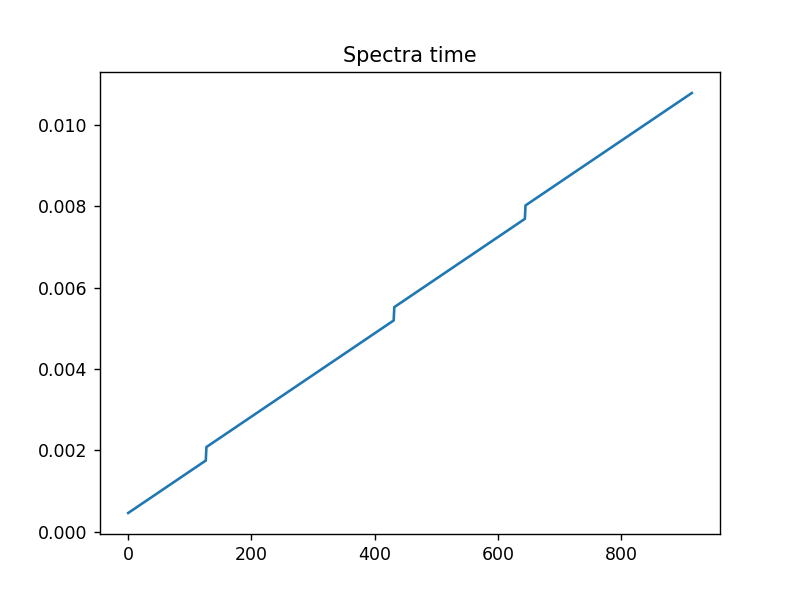

Text(0.5, 1.0, 'Spectra time')

In [44]:
plt.figure()
plt.plot(spectra_time_array)
plt.title("Spectra time")

### When does each frame starts and ends?

We will use the data retrieve in the specta.txt and ShutterTimes.txt to figure out which file belongs to which frame

In [45]:
def find_nearest_index(array, value):
    perfect_match = (0 in (np.abs(np.array(array) - value)))
    idx = (np.abs(np.array(array) - value)).argmin()
    return perfect_match, idx

In [46]:
# testing find_nearest_index algo
array = np.arange(10)
value = 5.6
print(find_nearest_index(array, value))

(False, 6)


In [47]:
# This was implemented before looking at Anton's code. His code just use the nearest index, no matter if 
# it's start or end

# for _frame_index in shutter_dict.keys():
#     start_time = shutter_dict[_frame_index]['start_time']
#     perfect_match, nearest_start_index = find_nearest_index(spectra_time_array, start_time)
#     # for start index, no need to check for perfect match as we always get the next index (if not perfect match)
#     shutter_dict[_frame_index]['start_index'] = nearest_start_index

#     end_time = shutter_dict[_frame_index]['end_time']
#     perfect_match, nearest_end_index = find_nearest_index(spectra_time_array, end_time)
#     # we need to check for perfect match or not. if not, we need to use the previous index
#     nearest_index = nearest_end_index if perfect_match else nearest_end_index - 1
#     shutter_dict[_frame_index]['end_index'] = nearest_index

for _frame_index in shutter_dict.keys():
    start_time = shutter_dict[_frame_index]['start_time']
    perfect_match, nearest_start_index = find_nearest_index(spectra_time_array, start_time)
    shutter_dict[_frame_index]['start_index'] = nearest_start_index

    end_time = shutter_dict[_frame_index]['end_time']
    perfect_match, nearest_end_index = find_nearest_index(spectra_time_array, end_time)
    shutter_dict[_frame_index]['end_index'] = nearest_end_index

    
# make list of runs for each frame
for _frame_index in shutter_dict.keys():
    start_index = shutter_dict[_frame_index]['start_index']
    end_index = shutter_dict[_frame_index]['end_index']
    shutter_dict[_frame_index]['list_runs'] = np.arange(start_index, end_index+1)

# Recap 

In [48]:
import pprint
pprint.pprint(shutter_dict)

{0: {'counts': 194873,
     'end_index': 126,
     'end_time': 0.0017595199999999999,
     'list_runs': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126]),
     'start_index': 0,
     'start_time': 0.00045904},
 1: {'counts': 195956,
     'end_index': 431,
     'end_time': 0.0052038399999999995,
     'list_runs': array([127, 128, 129, 130, 131

In [49]:
list_input_files = glob.glob(input_folder + '/*.fits')
list_input_files.sort()

# removing _SummedImg.fits
clean_list_input_files = []
for _file in list_input_files:
    if "_SummedImg.fits" in _file:
        continue
    clean_list_input_files.append(_file)

list_input_files = clean_list_input_files
    
o_norm = Normalization()
o_norm.load(file=list_input_files, notebook=True)

#### load expected data 

In [63]:
list_expected_input_files = glob.glob(expected_folder + '/*.fits')
list_expected_input_files.sort()
clean_list_expected_input_files = []
for _file in list_expected_input_files:
    if "_SummedImg.fits" in _file:
        continue
    clean_list_expected_input_files.append(_file)

list_expected_input_files = clean_list_expected_input_files

o_expected = Normalization()
o_expected.load(file=list_expected_input_files, notebook=True)

expected_data = o_expected.data['sample']['data']
expected_profile = [np.mean(_data) for _data in expected_data[:][:]]

# Code 

In [51]:
raw_data = o_norm.data['sample']['data']
pixel_occupancy_probablity = np.zeros(np.shape(raw_data))

In [52]:
shutter_n_ratio_array = np.ones((len(list_input_files)))
for shutter_index in shutter_dict.keys():
    list_runs = shutter_dict[shutter_index]['list_runs']
    shutter_counts = shutter_dict[shutter_index]['counts']
    starting_run = list_runs[0]
    shutter_n_ratio = shutter_counts / shutter_dict[0]['counts']
    for _run in list_runs[1:]:
        pixel_occupancy_probablity[:][:][_run] = np.sum(raw_data[:][:][starting_run: _run], 0) / np.float(shutter_counts)
        shutter_n_ratio_array[_run] = shutter_n_ratio


In [95]:
data_corrected = raw_data / (1 - pixel_occupancy_probablity)

In [120]:
new_data_corrected = np.zeros((np.shape(data_corrected)))
for _index, _data in enumerate(data_corrected):
    new_data = _data / shutter_n_ratio_array[_index]
    new_data_corrected[_index] = new_data
    
data_corrected = new_data_corrected

# Checking raw and corrected data 

In [56]:
raw_profile = [np.mean(_data) for _data in raw_data[:][:]]
corrected_profile = [np.mean(_data) for _data in data_corrected[:][:]]


<IPython.core.display.Javascript object>


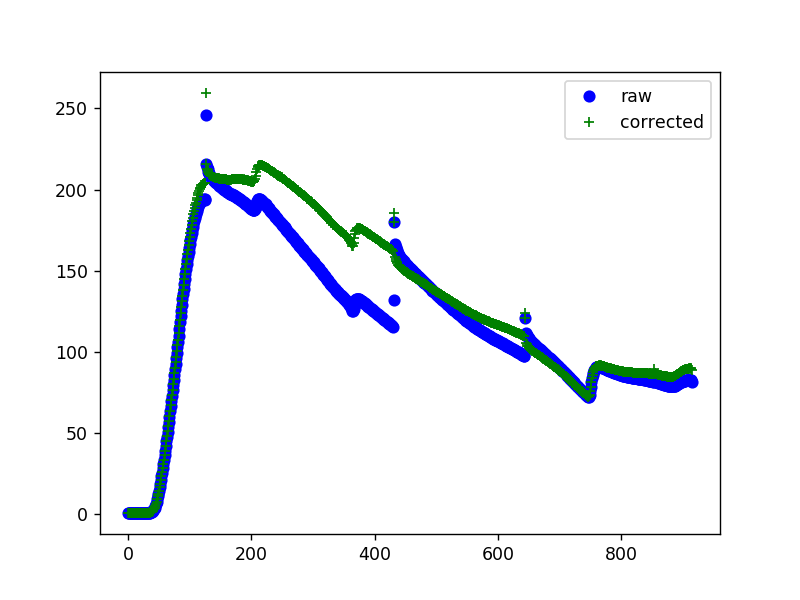

In [57]:
plt.figure()
plt.plot(raw_profile,'bo', label='raw')
# plt.plot(corrected_profile_without_removing_anything, 'r.', label='no data removed')
plt.plot(corrected_profile, 'g+', label='corrected')
plt.legend()

# Compare profile with expected profile

<IPython.core.display.Javascript object>


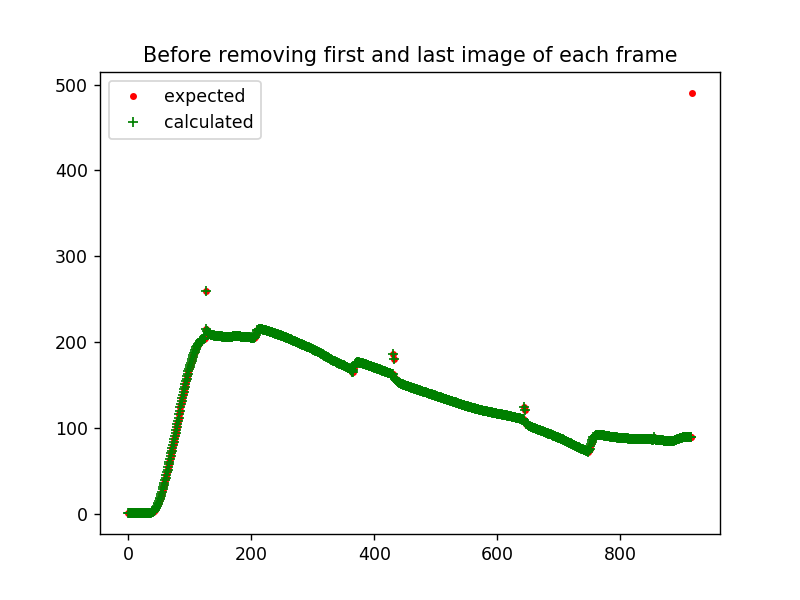

In [58]:
plt.figure()
plt.plot(expected_profile, 'r.', label='expected')
plt.plot(corrected_profile, 'g+', label='calculated')
plt.title("Before removing first and last image of each frame")
plt.legend()

<IPython.core.display.Javascript object>


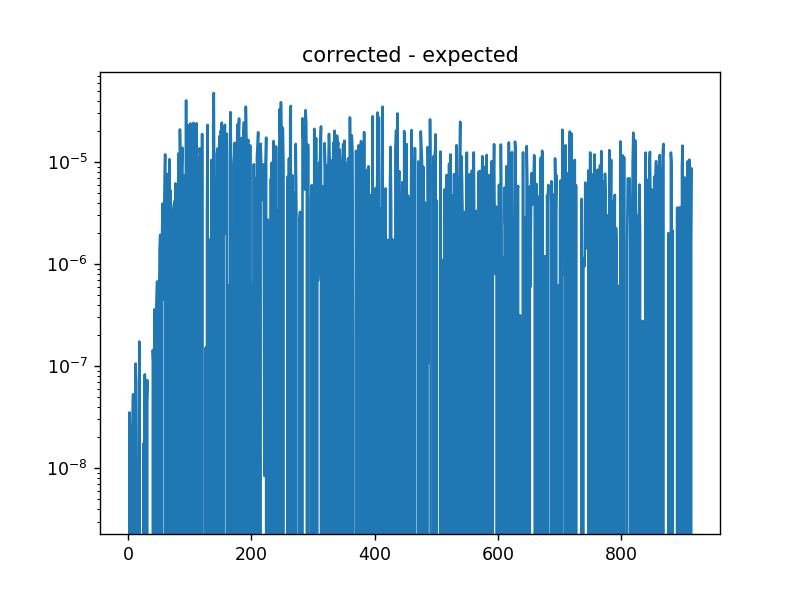

Text(0.5, 1.0, 'corrected - expected')

In [64]:
diff = np.array(corrected_profile) - np.array(expected_profile)

plt.figure()
plt.semilogy(diff)
plt.title("corrected - expected")

# Remove first and last image of each frame 

#### Following cell is just to be run to test the remove first and last algorithm works 

In [121]:
list_input_files = glob.glob(input_folder + '/*.fits')
list_input_files.sort()

# removing _SummedImg.fits
clean_list_input_files = []
for _file in list_input_files:
    if "_SummedImg.fits" in _file:
        continue
    clean_list_input_files.append(_file)

list_input_files = clean_list_input_files
    

spectra_file_pd = pd.read_csv(spectra_file, sep='\t', names=['shutter_time',
                                                             'counts'])
spectra_time_array_before_cleaning = np.array(spectra_file_pd['shutter_time'])

data_corrected = raw_data / (1 - pixel_occupancy_probablity)
new_data_corrected = np.zeros((np.shape(data_corrected)))
for _index, _data in enumerate(data_corrected):
    new_data = _data / shutter_n_ratio_array[_index]
    new_data_corrected[_index] = new_data
    
data_corrected = new_data_corrected

#### Code that removes data from first and last index in each frame 

In [122]:
# because we are going to remove files and infos via index, we need to start from the end
list_shutter = list(shutter_dict.keys())
list_shutter.sort()
reverse_list_shutter = list_shutter[::-1]
for frame_index in reverse_list_shutter:
    end_index = shutter_dict[frame_index]['end_index']
    list_input_files = np.delete(list_input_files, end_index)
    data_corrected = np.delete(data_corrected, end_index, 0)
    spectra_file_pd.drop(end_index, inplace=True)
    
    start_index = shutter_dict[frame_index]['start_index']
    list_input_files = np.delete(list_input_files, start_index)
    data_corrected = np.delete(data_corrected, start_index, 0)
    spectra_file_pd.drop(start_index, inplace=True)
    
spectra_time_array_after_cleaning = np.array(spectra_file_pd['shutter_time'])

In [124]:
# only used for testing the profile
corrected_profile_with_data_removed = [np.mean(_data) for _data in data_corrected[:][:]]
spectra_time_array = np.array(spectra_file_pd['shutter_time'])

plt.figure()
plt.plot(spectra_time_array_before_cleaning, expected_profile, 'r.', label='expected')
plt.plot(spectra_time_array_after_cleaning, corrected_profile_with_data_removed, 'g+', label='data removed')
plt.title("after removing first and last image of each frame")
plt.legend()

# export data 

In [145]:
short_list_input_files = [os.path.basename(_file) for _file in list_input_files]
o_norm.data['sample']['data'] = data_corrected
o_norm.export(folder=output_folder, data_type='sample')